In [1]:
import numpy as np, curvedsky as cs, sys, plottools as pl, local, tools_cmb, tqdm
from matplotlib.pyplot import *

In [2]:
def aps_read(qids,wtype='com16v3pt'):
    aobj = {q: local.init_analysis_params(qid=q,wtype=wtype,ascale=3.0) for q in qids}
    mcl  = {q: (np.loadtxt(aobj[q].fscl['c'])).T[1] for q in qids}
    ncl  = {q: (np.loadtxt(aobj[q].fscl['n'])).T[1] for q in qids}
    return aobj, mcl, ncl

In [3]:
def SNR(L,ckk,nkk,Lmin=40,Lmax=2048,fsky=0.01436):
    snr = np.sqrt( fsky * np.sum( (L[Lmin:Lmax+1]+.5)*ckk[Lmin:Lmax+1]**2/(ckk+nkk)[Lmin:Lmax+1]**2 ) )
    print(snr)
    return snr

In [4]:
def comb_Nl(qids,mcl,ncl,cTT):
    Nl = 0.
    for q in qids:
        flT = (mcl[q]-ncl[q])/cTT
        flT = 1.
        Nl += flT/ncl[q]
    Nl = 1./Nl
    return Nl

In [5]:
qids_d = ['boss_d01','boss_d02','boss_d03','boss_d04','s16_d01','s16_d02','s16_d03']
qids_n = local.boss_n
qids_d_sub = ['boss_d02','boss_d03','boss_d04']
qids_n_sub = local.boss_dn
qids_t = qids_d + qids_n
comb = ['d','n','dsub','nsub','dn']

In [6]:
aobj, mcl, ncl = aps_read(qids_t,wtype='com16v3pt')
#aobj, mcl, ncl = aps_read(qids_t,wtype='iso15v3pt')
cTT = aobj[qids_t[0]].lcl[0,:]
cTE = aobj[qids_t[0]].lcl[3,:]
cEE = aobj[qids_t[0]].lcl[1,:]
lcl = aobj[qids_t[0]].lcl[:4,:]

In [7]:
Ncl = {}
Ncl['d'] = comb_Nl(qids_d,mcl,ncl,cTT)
Ncl['n'] = comb_Nl(qids_n,mcl,ncl,cTT)
Ncl['dsub'] = comb_Nl(qids_d_sub,mcl,ncl,cTT)
Ncl['nsub'] = comb_Nl(qids_n_sub,mcl,ncl,cTT)
Ncl['dn'] = 1./(1./Ncl['d']+1./Ncl['n'])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [8]:
ocl = {}
for c in comb:
    ocl[c] = lcl.copy()
    ocl[c][0,:] += Ncl[c]
    ocl[c][1,:] += 2*Ncl[c]
    ocl[c][2,:] += 2*Ncl[c]

In [9]:
Lmax = 2048
rlmax = 3000
L = np.linspace(0,Lmax,Lmax+1)
ckk = aobj[qids_t[0]].ckk[:Lmax+1]
rlmin = 500

In [10]:
Ag = {}
for c in comb:
    print(c)
    QDO = [True,True,True,True,True,False]
    Ag['MV',c], __, __, __ = cs.norm_lens.qall(QDO,Lmax,rlmin,rlmax,lcl[:,:rlmax+1],ocl[c][:,:rlmax+1],gtype='k')

d
n
dsub
nsub
dn


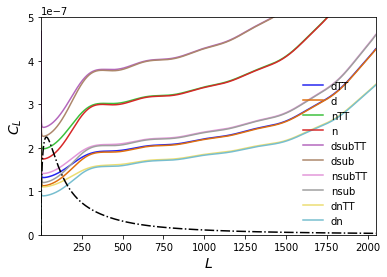

In [11]:
pl.plot_1dstyle(xmin=1,xmax=Lmax,ymin=0,ymax=5e-7)
for c in comb:
    plot(L,Ag['MV',c][0,:],label=c+'TT')
    plot(L,Ag['MV',c][5,:],label=c)
plot(L,ckk,color='k',ls='-.')
legend()

In [12]:
for q in [0,5]:
    for c in comb:
        print(q,c)
        SNR(L,ckk,Ag['MV',c][q])
        #SNR(L,ckk,Ag['MV',c][q],Lmin=50)
        #SNR(L,ckk,Ag['MV',c][q],Lmin=50,Lmax=1000)

0 d
13.389451686730679
0 n
9.662860418906941
0 dsub
8.094244249998129
0 nsub
12.695246684827882
0 dn
15.23939608019756
5 d
13.75082740214143
5 n
9.945002191172389
5 dsub
8.280984055411405
5 nsub
13.063636067212359
5 dn
15.7389980799023


In [13]:
rlmins = np.arange(1000,400,-100)
SN_d = np.zeros(len(rlmins))
SN_n = np.zeros(len(rlmins))
SN_t = np.zeros(len(rlmins))
for i, rlmin in enumerate(rlmins):
    Ag = {}
    for q in tqdm.tqdm(qids_t):
        Ag[q], __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],(cTT+ncl[q])[:rlmax+1],gtype='k')
    Ag_d, __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],ocl['d'][0,:rlmax+1],gtype='k')
    Ag_n, __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],ocl['n'][0,:rlmax+1],gtype='k')
    Ag_t, __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],ocl['dn'][0,:rlmax+1],gtype='k')
    SN_d[i] = SNR(L,ckk,Ag_d)
    SN_n[i] = SNR(L,ckk,Ag_n)
    SN_t[i] = SNR(L,ckk,Ag_t)

  9%|▉         | 1/11 [00:02<00:20,  2.03s/it]

12.551105948582753
8.790573821459832
14.384135893900378


  9%|▉         | 1/11 [00:02<00:20,  2.06s/it]

12.741660681219058
8.986833989630579
14.579257964969194


  0%|          | 0/11 [00:00<?, ?it/s]

13.082572189185969
9.363053583663262
14.915803077897944


  0%|          | 0/11 [00:00<?, ?it/s]

13.247508629597425
9.525105074120066
15.087185970030117


  9%|▉         | 1/11 [00:01<00:19,  1.94s/it]

13.320290874025625
9.59341842296867
15.165799073238853


100%|██████████| 11/11 [00:22<00:00,  2.02s/it]


13.389451686730679
9.662860418906941
15.23939608019756


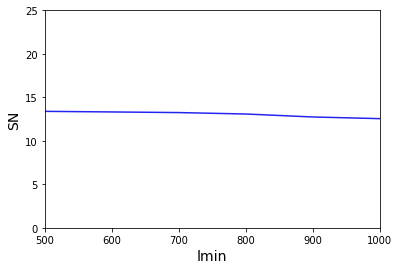

In [14]:
pl.plot_1dstyle(xmin=500,xmax=1000,ymin=0,ymax=25,xlab='lmin',ylab='SN')
plot(rlmins,SN_d)

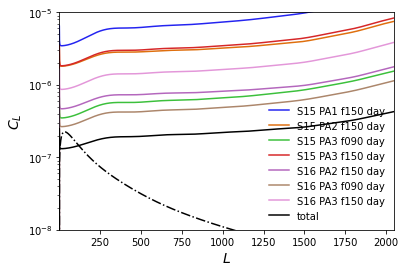

In [15]:
pl.plot_1dstyle(ylog=True,xmin=1,xmax=Lmax,ymin=1e-8,ymax=1e-5)
for q in qids_d:
    plot(L,Ag[q],label=local.qid_label(q))
plot(L,Ag_d,'-',label='total',color='k')
plot(L,ckk,color='k',ls='-.')
legend()

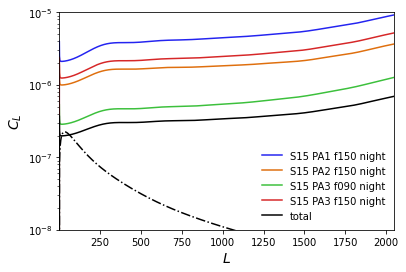

In [16]:
pl.plot_1dstyle(ylog=True,xmin=1,xmax=Lmax,ymin=1e-8,ymax=1e-5)
for q in qids_n:
    plot(L,Ag[q],label=local.qid_label(q))
plot(L,Ag_n,'-',label='total',color='k')
plot(L,ckk,color='k',ls='-.')
legend()

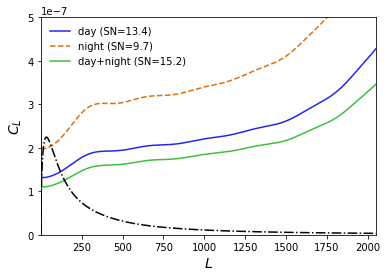

In [17]:
pl.plot_1dstyle(ylog=False,xmin=1,xmax=Lmax,ymin=0.,ymax=5e-7)
plot(L,Ag_d,'-',label='day (SN='+str(np.round(SN_d[-1],1))+')')
plot(L,Ag_n,'--',label='night (SN='+str(np.round(SN_n[-1],1))+')')
plot(L,Ag_t,'-',label='day+night (SN='+str(np.round(SN_t[-1],1))+')')
plot(L,ckk,color='k',ls='-.')
legend()